In [1]:
#!pip install --user -U pip

In [2]:
#!pip install --user umap-learn

In [3]:
#!pip install --user -U seaborn

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from umap import UMAP

In [5]:
# chr5:3,566,700-3,567,700
# http://ucsc.gao-lab.org/cgi-bin/hgTracks?db=tair10&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=Chr5%3A3566700%2D3567700&hgsid=164617_9lNIGAWPpARSj47ipyGVNh4OanwR
embedding = np.loadtxt("example_embedding.txt")
embedding.shape

(1000, 512)

In [6]:
latent = PCA(n_components=20).fit_transform(embedding)
latent.shape

(1000, 20)

In [7]:
pca = latent[:, :2]
pca.shape

(1000, 2)

In [8]:
umap = UMAP(n_components=2).fit_transform(latent)
umap.shape

(1000, 2)

In [9]:
cluster = KMeans(n_clusters=10).fit_predict(latent)
cluster.shape

(1000,)

In [10]:
df = pd.DataFrame(dict(
    pos=np.arange(len(pca)),
    PC1=pca[:, 0],
    PC2=pca[:, 1],
    UMAP1=umap[:, 0],
    UMAP2=umap[:, 1],
    cluster=cluster,
))
df

,pos,PC1,PC2,UMAP1,UMAP2,cluster
0,0,50.100275,47.033956,-1.997581,-1.499112,0
1,1,-15.581747,58.113229,3.939169,1.259042,9
2,2,42.981641,48.829378,-1.950673,-1.527698,0
3,3,57.940017,44.216418,-1.919837,-1.565005,0
4,4,54.583325,44.338956,-2.005317,-1.508748,0
...,...,...,...,...,...,...
995,995,-54.021989,4.442022,15.721426,8.985989,5
996,996,37.537841,-38.226426,3.382890,-7.703012,8
997,997,-60.360278,-4.954267,15.443886,9.104552,5
998,998,-57.236034,-2.336900,15.399879,9.095137,5


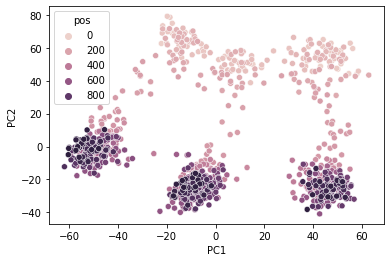

In [11]:
sns.scatterplot(data=df, x="PC1", y="PC2", hue="pos")

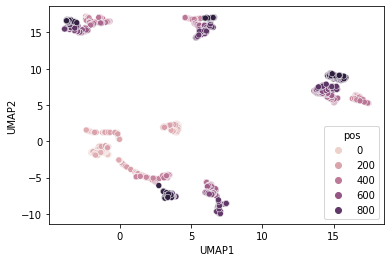

In [12]:
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="pos")

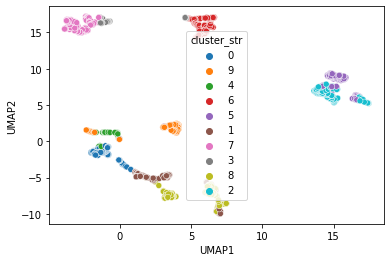

In [13]:
df["cluster_str"] = df.cluster.astype(str)
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", hue="cluster_str")

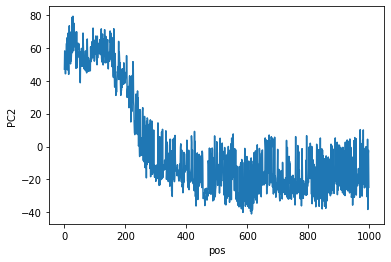

In [14]:
sns.lineplot(data=df, x="pos", y="PC2")

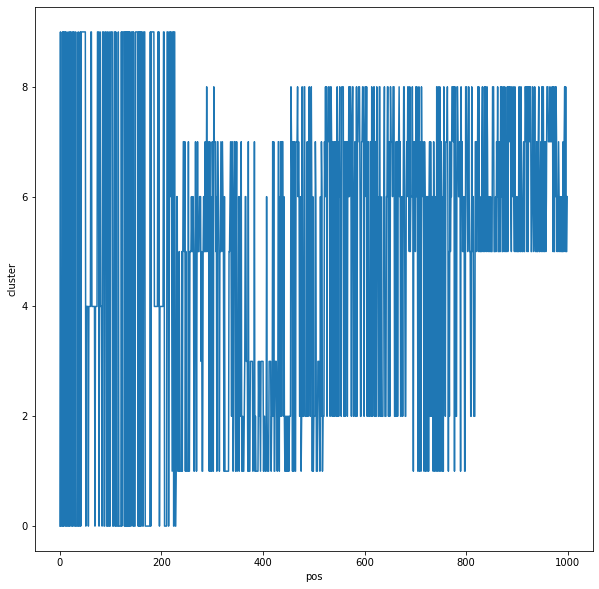

In [15]:
plt.figure(figsize=(10, 10))
sns.lineplot(data=df, x="pos", y="cluster")

In [18]:
df2 = pd.DataFrame(data=latent.T)
df2

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,50.100275,-15.581747,42.981641,57.940017,54.583325,15.306581,41.389149,-22.234577,37.491975,-14.584888,...,-60.202626,-13.658100,-56.501513,-17.277861,46.024064,-54.021989,37.537841,-60.360278,-57.236034,-13.054298
1,47.033956,58.113229,48.829378,44.216418,44.338956,49.930868,55.056052,62.655153,52.027784,66.154626,...,-1.124773,-20.657221,-0.094709,-30.017396,-30.610434,4.442022,-38.226426,-4.954267,-2.336900,-24.758450
2,-5.098236,-9.064086,-4.322805,-1.361605,-9.083394,44.278580,-0.487366,-13.539372,4.142975,-3.819752,...,-28.950410,56.907561,-28.179281,56.152495,-27.404885,-32.666485,-33.284481,-33.117010,-33.020584,20.590199
3,-7.806956,-6.982320,-9.304490,-8.298747,-9.931862,-27.986029,-15.732766,-4.963136,-6.368076,-5.307377,...,-11.079881,-43.754591,-11.576345,-33.336934,-11.528171,-5.992242,-5.933789,-9.581722,-8.661144,50.875450
4,-11.875239,-12.027066,-5.385128,-8.498495,-7.603271,-14.307221,-3.931718,-6.470628,-5.282375,-2.076065,...,-32.998899,-40.029709,-27.357554,-43.976303,-31.935251,-20.446765,-32.535290,-22.849741,-21.184433,-28.903568
5,-9.526959,-19.391800,-12.094953,-8.835158,-9.578289,-3.615687,-10.428548,-9.723849,-6.509345,-8.161848,...,-14.165765,-14.626995,-11.149701,-13.055457,-11.836495,-10.158047,-8.957530,-16.378432,-16.462137,-19.106694
6,-9.279460,-18.148132,-19.165161,-19.886597,-17.830455,-20.803215,-18.083730,-22.094173,-17.560567,-21.529572,...,7.889627,9.911294,15.581127,11.659106,1.216878,8.160382,14.285847,2.630735,11.572715,-12.708509
7,-19.876493,0.615938,-9.455662,-8.121117,-12.746374,15.712396,10.621095,-2.026523,2.656544,4.045653,...,-13.358713,-11.845834,-8.418534,0.014540,-31.151148,-2.938888,-33.040341,-13.816564,-11.110283,-23.011198
8,4.348421,6.649972,15.698461,3.621878,-2.714093,-2.543924,-0.598460,4.265845,4.518412,-1.800570,...,2.052541,4.416340,3.799689,12.720319,6.929517,26.639442,10.841903,22.591159,16.782615,11.989503
9,-6.685811,-4.188861,-2.192708,-7.089576,-4.357174,1.720818,4.828799,-6.764016,-4.953076,-2.036334,...,2.275033,-1.186484,6.880332,3.382754,2.995587,8.508307,-13.239308,3.564446,-6.579846,-23.155853


Text(114.0, 0.5, 'embedding principal component')

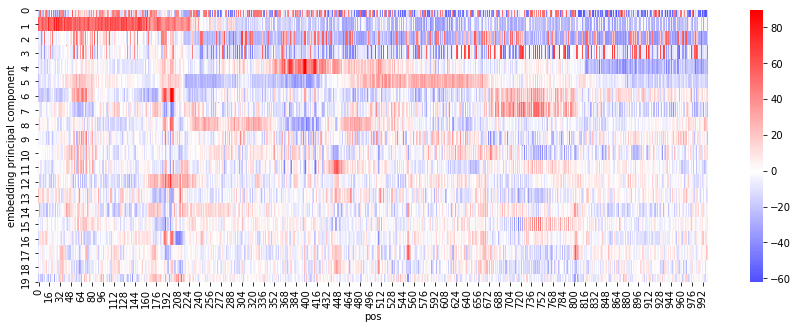

In [35]:
plt.figure(figsize=(15, 5))
sns.heatmap(
    data=df2,
    cmap="bwr",
    center=0,
    square=False,
    yticklabels=1,
)
plt.xlabel("pos")
plt.ylabel("embedding principal component")

Text(114.0, 0.5, 'embedding principal component')

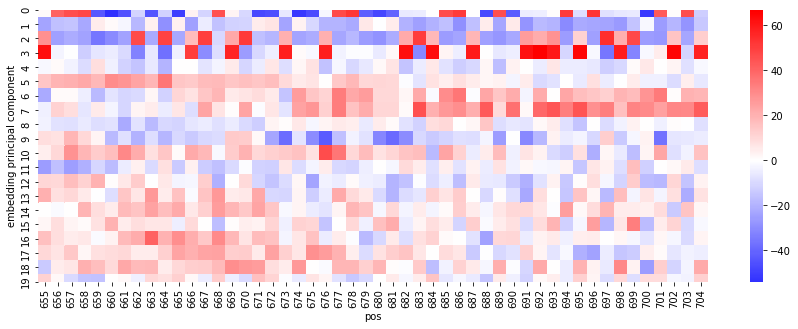

In [36]:
plt.figure(figsize=(15, 5))
sns.heatmap(
    data=df2.iloc[:, 655:705],
    cmap="bwr",
    center=0,
    square=False,
    yticklabels=1,
)
plt.xlabel("pos")
plt.ylabel("embedding principal component")

Text(114.0, 0.5, 'embedding principal component')

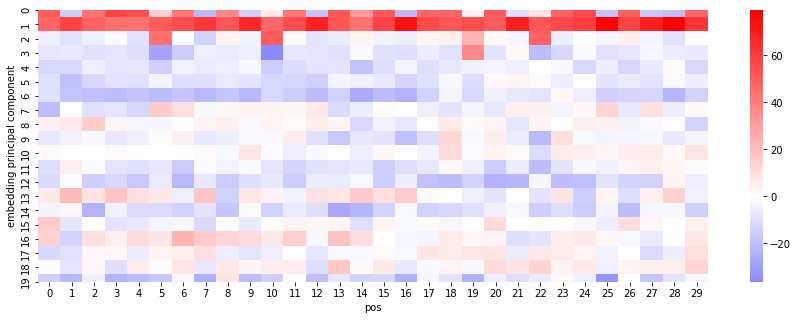

In [42]:
plt.figure(figsize=(15, 5))
sns.heatmap(
    data=df2.iloc[:, :30],
    cmap="bwr",
    center=0,
    square=False,
    yticklabels=1,
)
plt.xlabel("pos")
plt.ylabel("embedding principal component")

In [38]:
seq = "ATAAACATATCATAAATAAGATCAATATTAATAAAATAAATAGTTTTTTTTACGGGACGGATTGGCGGGACGAGTTTAGCAGGACGTAACTTAATAACAATTGTAAACTATAAAATAAAAATATTTTATAGATAGATACAATTTGCAAACTTTTATATATACTAACTTAAAAAAAAAATATTGTCCCCTGCGGTATAAGACGGGTTAAAAATCTAGTTGTTATTATTAAAGGAAATAAAATATCCTCATAAAACAATTTGTTGTAATCTATCTTTGGGCTAATGTTCTTATCCTACAAGACGAACCCTGACCGTATTCGTCGTAGAAAAAAAATTGCTTCGATCCCATCATTGAGTTCAATAATCGGCGCACAAAGGCCGATTCATAAAAACTCTAGGCCCATTAAAGTAAAGCCCATTCTCAACCCTATCCAGTCTCCCTGTATATATATATTTACGACACCAACCCAGCGTTGATATTTAATTTTCTTCAGTCAGAGATTTCGAAACCCTAGTCGATTTCGAGATCCAACTAACTCTGCTCCTTATCTCAGGTAAAATTCTCGCTCGAGAACTCAATTGCTTATCCAAAGTTCCAACTGAAGATGCTTTCCTACTGAATCTTAGGTTAATGTTTTGGATTTGGAATCTTACCCGAAATTTCTCTGCAGCTTGTTGAATTTGCGAAGTATGGGAGACGCTAGAGACAACGAAGCCTACGAGGAGGAGCTCTTGGACTATGAAGAAGAAGACGAGAAGGTCCCAGATTCTGGAAACAAAGTTAACGGCGAAGCTGTGAAAAAGTGAGTTTTATGGTTTCCTCGATATGTTTCATGTATACTACTGTGTGTTTAAATTTGTCGATTCTTAGATTACTACTTGATAACAAGTAGCAGTATGTGTTTAATTAGTTGCTTAACATATAACAATTGACTGAGTTCTTCATTGCTATAATTCCTGAAACCCACCCAATATTAGACTGTCGTGTGTTTCTCATATTG"

In [41]:
seq[:30]

'ATAAACATATCATAAATAAGATCAATATTA'